In [1]:
# from quantbt.data import fetch_binance_data
from quantbt.data.fetch_binance_data import fetch_binance_data, fetch_futures_data
from quantbt.indicators import talib_SMA, talib_EMA
from binance.client import Client
from quantbt.lib import time_manip
import binance
import pandas as pd
from datetime import datetime

In [1]:
# Wrapper around python-binance that fetches spot data for the past 365 days
fetch_binance_data(
    assets=["BTCUSDT"],
    tf=Client.KLINE_INTERVAL_1MINUTE,
    days="365 day ago UTC",
    save_location="data",
)

Getting data for BTCUSDT on 1m


In [2]:
# Wrapper around python-binance that fetched futures data
# On the 1min timeframe, the count value is equal to number of days approximately
# You can choose one of 3 contract types: PERPETUAL, CURRENT_QUARTER, NEXT_QUARTER
fetch_futures_data("BTCUSDT", 365, "1m", "PERPETUAL")
fetch_futures_data("BTCUSDT", 365, "1m", "CURRENT_QUARTER")

2023-11-02 14:23:49.539892
2023-11-01 09:24:00
2023-10-31 08:25:00
2023-10-30 07:26:00
2023-10-29 06:27:00
2023-10-28 05:28:00
2023-10-27 04:29:00
2023-10-26 03:30:00
2023-10-25 02:31:00
2023-10-24 01:32:00
2023-10-23 00:33:00
2023-10-21 23:34:00
2023-10-20 22:35:00
2023-10-19 21:36:00
2023-10-18 20:37:00
2023-10-17 19:38:00
2023-10-16 18:39:00
2023-10-15 17:40:00
2023-10-14 16:41:00
2023-10-13 15:42:00
2023-10-12 14:43:00
2023-10-11 13:44:00
2023-10-10 12:45:00
2023-10-09 11:46:00
2023-10-08 10:47:00
2023-10-07 09:48:00
2023-10-06 08:49:00
2023-10-05 07:50:00
2023-10-04 06:51:00
2023-10-03 05:52:00
2023-10-02 04:53:00
2023-10-01 03:54:00
2023-09-30 02:55:00
2023-09-29 01:56:00
2023-09-28 00:57:00
2023-09-26 23:58:00
2023-09-25 22:59:00
2023-09-24 22:00:00
2023-09-23 21:01:00
2023-09-22 20:02:00
2023-09-21 19:03:00
2023-09-20 18:04:00
2023-09-19 17:05:00
2023-09-18 16:06:00
2023-09-17 15:07:00
2023-09-16 14:08:00
2023-09-15 13:09:00
2023-09-14 12:10:00
2023-09-13 11:11:00
2023-09-12 10

<Axes: >

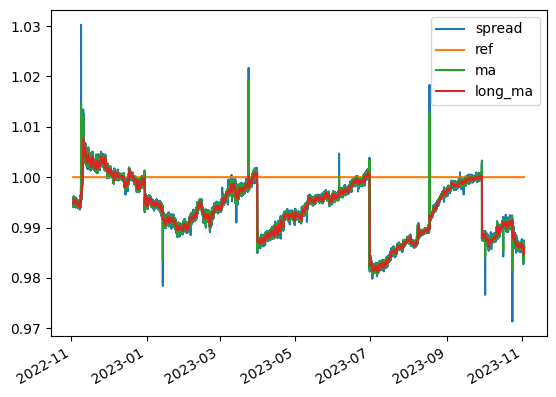

In [5]:
class Spread:
    def __init__(self, asset_1_file, asset_2_file):
        self.df_1 = pd.read_parquet(asset_1_file)
        self.df_2 = pd.read_parquet(asset_2_file)
        self.df_1["close"] = self.df_1["close"].astype(float)
        self.df_2["close"] = self.df_2["close"].astype(float)

        self.create_spread()

    def create_spread(self):
        merged_df = pd.merge(
            self.df_1["close"],
            self.df_2["close"],
            left_index=True,
            right_index=True,
            how="outer",
        )
        merged_df.dropna(inplace=True)
        merged_df.columns = ["df1", "df2"]

        self.spread = merged_df["df1"] / merged_df["df2"]

    def create_indicators(self, short=3, long=200, start=0, end=-1):
        df = pd.concat([self.spread, self.spread, self.spread, self.spread], axis=1)
        df.columns = ["spread", "ref", "ma", "long_ma"]

        df = df[start:end]

        df["ref"] = 1
        df["ma"] = talib_SMA(df["spread"], short)
        df["long_ma"] = talib_SMA(df["spread"], long)
        self.df = df
        return self.df

    def plot(self, start=0, end=-1):
        df = self.df
        df["spread"].plot(linestyle="None", marker="+", markersize=5)
        df["ref"].plot()
        df["ma"].plot()
        df["long_ma"].plot()
        plt.show()
        return df


perp_spread = Spread(
    "../data/binance-BTCUSDT-1m.parquet",
    "../data/binance-BTCUSDT-PERPETUAL-1m.parquet",
)
perp = perp_spread.create_indicators()


quarter_spread = Spread(
    "../data/binance-BTCUSDT-1m.parquet",
    "../data/binance-BTCUSDT-CURRENT_QUARTER-1m.parquet",
)
# df = quarter_spread.plot(start=5000, end=10000)
# df = quarter_spread.plot(start=8300, end=9500)
# df = quarter_spread.plot(start=8300, end=9500)
quarter = quarter_spread.create_indicators(short=3, long=300)
quarter.plot()

In [4]:
from numba import njit, prange
import numpy as np


def backtest(df):
    @njit(cache=True, nogil=True, parallel=True)
    def calculate_signals(spread, ma, long_ma):
        entry = np.full_like(spread, False, dtype=np.bool_)
        exit = np.full_like(spread, False, dtype=np.bool_)

        for i in prange(1, len(spread)):
            # Calculate the middle of highest and lowest in window
            if spread[i - 1] > 1 and spread[i] > 1:
                if spread[i - 1] > ma[i - 1] and spread[i] < ma[i]:
                    entry[i] = True

            if spread[i - 1] < 1 and spread[i] < 1:
                if spread[i - 1] < long_ma[i - 1] and spread[i] > long_ma[i]:
                    exit[i] = True
        return entry, exit

    entry, exit = calculate_signals(
        df["spread"].values, df["ma"].values, df["long_ma"].values
    )

    @njit(cache=True)
    def run_backtest(entry, exit, spread):
        positions = []
        position = 0
        for i in range(len(entry)):
            if position == 0 and entry[i]:
                # print("Entry", i)
                position = spread[i]
            if position > 0 and exit[i]:
                pnl = position - spread[i]
                positions.append(pnl * 100)
                position = 0
        return positions

    positions = run_backtest(entry, exit, df["spread"].values)
    stats = pd.Series(positions)

    backtest_time = df.index[-1] - df.index[0]
    ROI = stats.sum()

    print("The backtest ran on {} days".format(backtest_time.days))
    print("The ROI without fees is {}%".format(round(ROI, 2)))


print("============  Backtesting on SPOT-PERP  ==============")
backtest(perp)

print()
print("============  Backtesting on SPOT-QUARTER  ==============")
print("============  ShortMA = 3, LongMA = 300  ==============")
quarter = quarter_spread.create_indicators(short=3, long=300)
backtest(quarter)

print()
print("============  Backtesting on SPOT-QUARTER  ==============")
print("============  ShortMA = 55, LongMA = 100  ==============")
quarter = quarter_spread.create_indicators(short=55, long=100)
backtest(quarter)

============  Backtesting on SPOT-PERP  ==============
The backtest ran on 365 days
The ROI without fees is 1.04%

============  Backtesting on SPOT-QUARTER  ==============
============  ShortMA = 3, LongMA = 300  ==============
The backtest ran on 365 days
The ROI without fees is 9.74%

============  Backtesting on SPOT-QUARTER  ==============
============  ShortMA = 55, LongMA = 100  ==============
The backtest ran on 365 days
The ROI without fees is 4.78%
